## Tutorial ARIMA Models

#### Prepared by
### Karzanov Daniil, Molostvov Pavel, Zobov Vladimir

The complete code from this tutorial is available [here](https://github.com/DKarz/tssp_tutorials_2020_21/blob/main/arima%20source.py).

## Table of Contents
1. [Goals](#goals)
2. [Imports](#imp)
3. [Data preparation](#dat)
4. [AutoARIMA](#aa)
5. [Splitting the Data, Fitting the Models and Getting Prediction](#spl)
6. [Comparison](#comp)
7. [Sliding Window ](#sld)
8. [Conclusion](#end)


## Goals <a name="goals"></a>

The main goals of this tutorial are to:

* 	Fit AutoARIMA model and show the model equation

* 	Fit ARIMA model with seasonality and without

* 	Fit NaïveForecaster 

* 	Compare the performance of all of them

* 	Make beautiful visualizations 


In statistics and econometrics, and in particular in time series analysis, an [autoregressive integrated moving average (ARIMA) model](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) is a generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting).

## Imports <a name="imp"></a>

First things first, we are are going to install and import modules needed for the tutorial.

In [2]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split, SlidingWindowSplitter, ForecastingGridSearchCV
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster
from sklearn.metrics import mean_absolute_percentage_error
from sktime.forecasting.arima import ARIMA, AutoARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings("ignore")

# setting graphs size
plt.rcParams["figure.figsize"] = [16,7]
# for fancy plots
plt.style.use('ggplot')

Note, while writing this report, the version of sktime module was 0.5.3. You may check your version of sktime in the following way:

In [3]:
from sktime import __version__ as sktime_version
print("sktime version", sktime_version)

sktime version 0.5.3


## Data preparation <a name="dat"></a>

In the period of a pandemic, it is essential to stay healthy. During such times, any medicine is vital. For this reason, we found a thematic dataset. We have downloaded the dataset called "Monthly anti-diabetic drug sales in Australia from 1991 to 2008" or a10. It contains two columns –the data of the record in format YYYY-MM and value that is total monthly scripts for pharmaceutical products falling under [ATC](http://www.hpra.ie/homepage/medicines/medicines-information/atc-codes#:~:text=The%20Anatomical%20Therapeutic%20Chemical%20(ATC,therapeutic%20indication%20for%20the%20medicine.) code A10, as recorded by the Australian Health Insurance Commission.

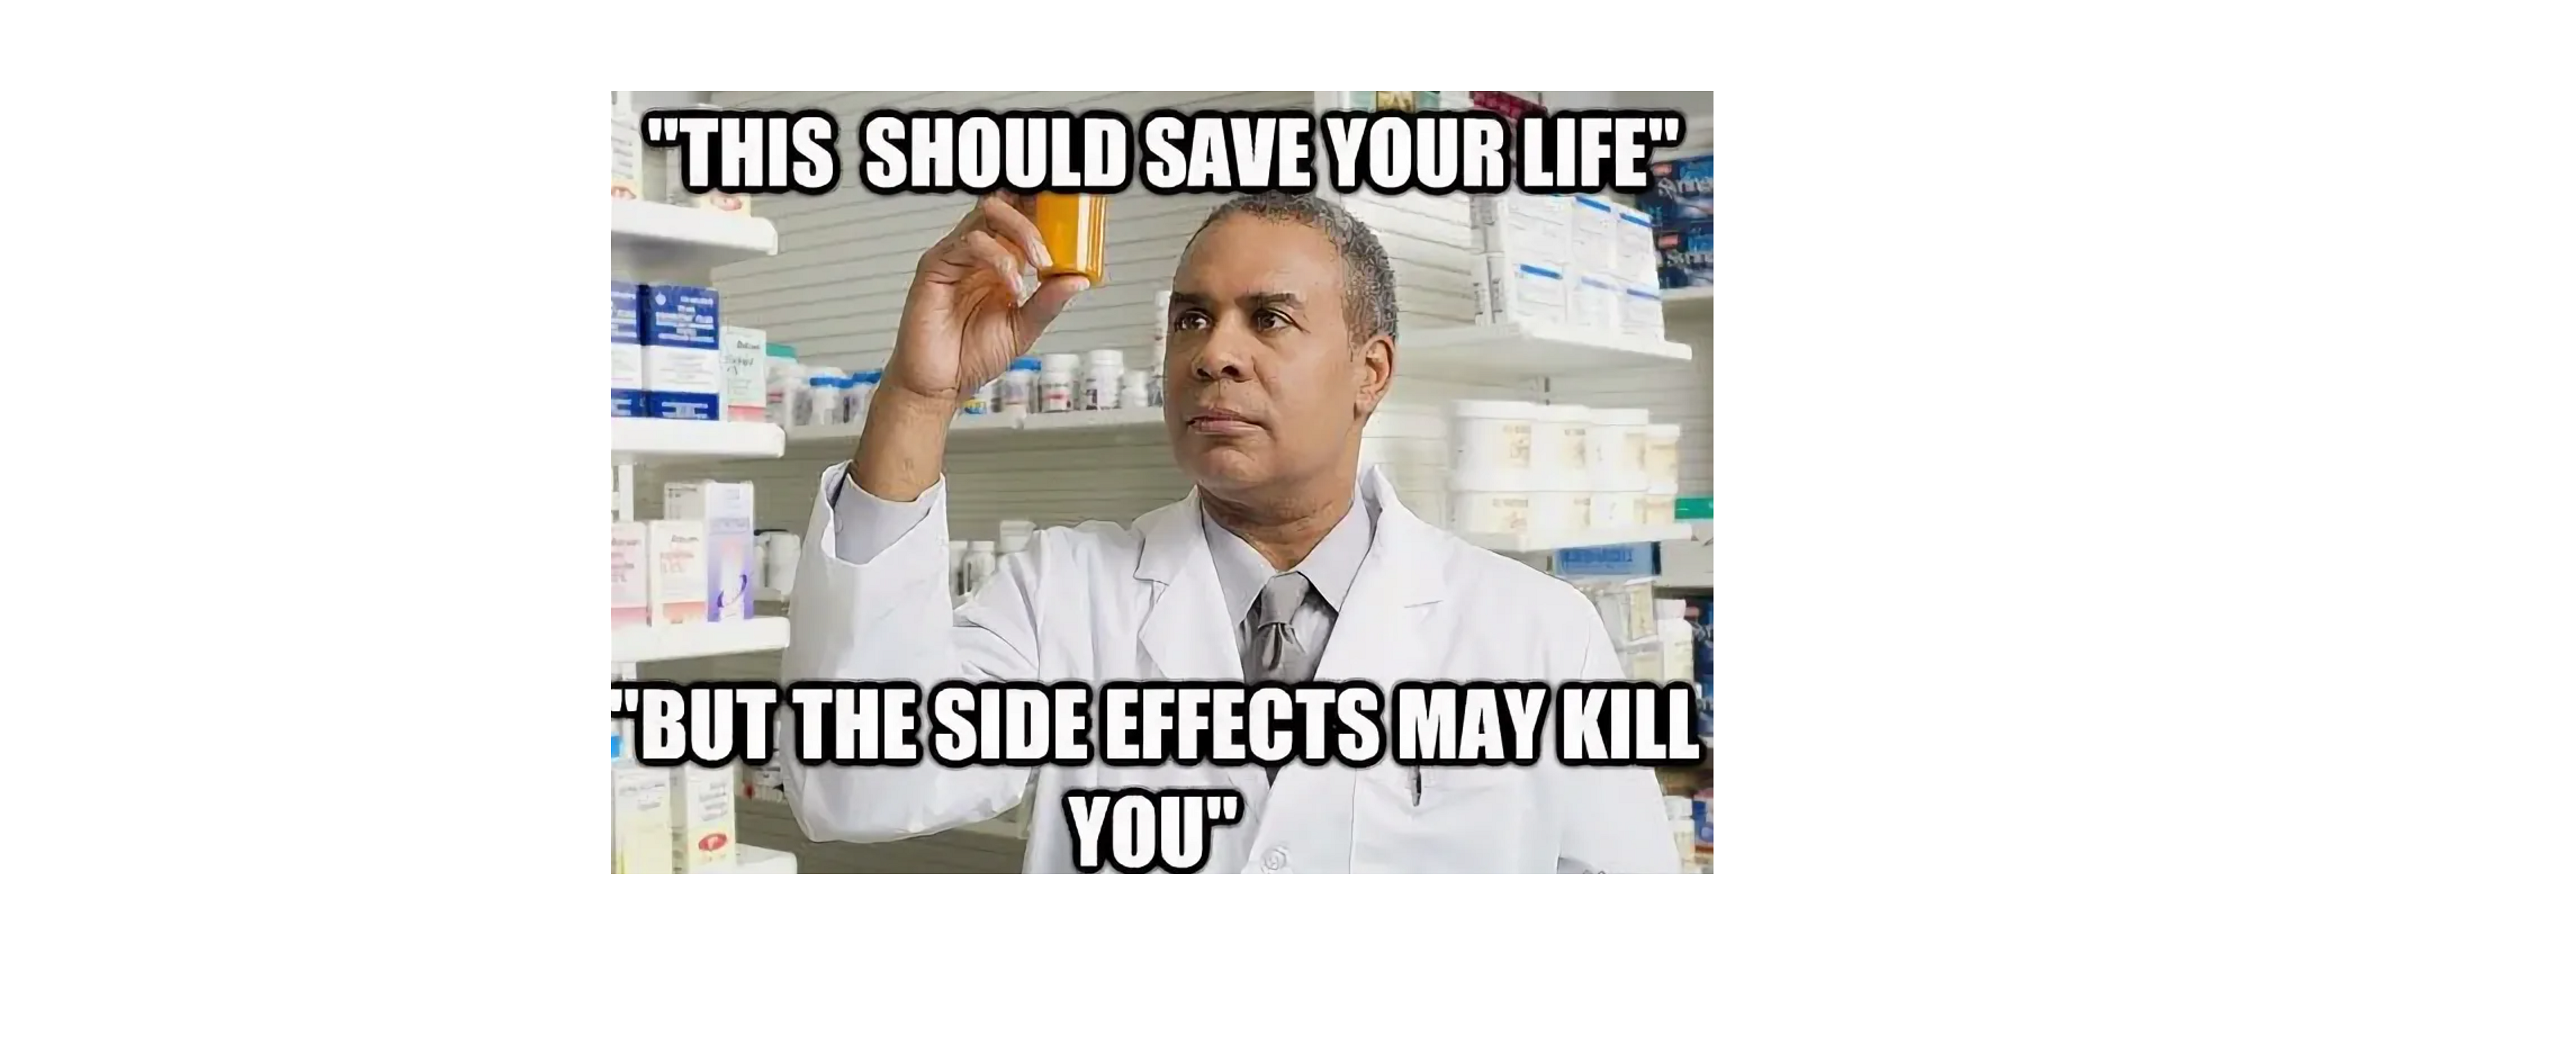

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                 parse_dates=['date'], index_col="date")

We need to specify the frequency before converting it to series.
It is a common practice of setting the index to the date. It is beneficial because, firstly, it is always easier to access the value by date. Also, it is needed for converting to series and plotting. 


In [5]:
df.index = pd.PeriodIndex(df.index, freq="M")

In this way we convert ```pandas.core.frame.DataFrame``` object to ```pandas.core.series.Series```.

In [6]:
series = df.T.iloc[0]

In [7]:
series

date
1991-07     3.526591
1991-08     3.180891
1991-09     3.252221
1991-10     3.611003
1991-11     3.565869
             ...    
2008-02    21.654285
2008-03    18.264945
2008-04    23.107677
2008-05    22.912510
2008-06    19.431740
Freq: M, Name: value, Length: 204, dtype: float64

As we can see from the table, each row in the dataframe represents a value for each month between july 1991 and june 2008.

We can plot the series, and the fastest method is using ```plot_series``` from ```sktime.utils.plotting```. As an alternative we can use either ```.plot()``` method of ```series``` object or you can plot with ```matplotlib```, but we will use the first approach now.

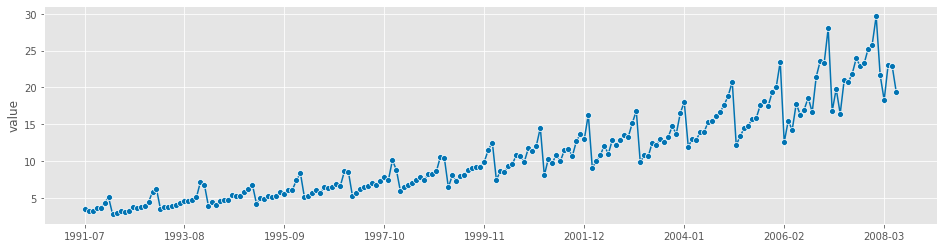

In [8]:
plot_series(series);

We can see that the value rises annualy. Also, we may observe a distinct seasonality with 12 month period. Amplitude increases with each year. Therefore, it will be reasonable to use the model with the seasonality* component. We will compare it with a similar model but without seasonality and see the prediction error

#### Definition
In time series data, **seasonality** is the presence of variations that occur at specific regular intervals less than a year, such as weekly, monthly, or quarterly. 
Seasonal fluctuations in a time series can be contrasted with cyclical patterns.

**As we can see from the plot, our data is seasonal with one year period.**

## Auto Arima <a name="aa"></a>

Let us run ```AutoARIMA``` function from ```sktime.forecasting.arima``` package. It will run all possible combinations of models given function parameters. We specify ```sp``` parameter to 12, because we have seasional fluctuations every 12 month. Also, we may hide the warnings messages. See
[documentation.](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.arima.AutoARIMA.html) for more detailed description of the parameters.

In [9]:
model_auto = AutoARIMA(sp=12, suppress_warnings=True).fit(series)

The main result of the model is a summary that provides important information about the parameters of the best found ARIMA model given the hyperparameters. The summary includes the values of the coefficients of the fitted model (with corresponding standard errors, z-statistics and p-values), and some metrics such as [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) and [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion).

In [10]:
summary = model_auto.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  204
Model:             SARIMAX(3, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -251.493
Date:                              Wed, 03 Mar 2021   AIC                            518.986
Time:                                      17:42:06   BIC                            545.004
Sample:                                           0   HQIC                           529.525
                                              - 204                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0097      0.005      1.988      0.047       0.000       0.019
ar.L1         -0.6190      0.124     -4.994      0.000      -0.862      -0.376
ar.L2          0.3010      0.100      2.995      0.003       0.104       0.498
ar.L3          0.4227      0.063      6.746      0.000       0.300       0.546
ma.L1         -0.3172      0.136     -2.330      0.020      -0.584      -0.050
ma.L2         -0.5878      0.122     -4.819      0.000      -0.827      -0.349
ma.S.L12      -0.4646      0.066     -7.075      0.000      -0.593      -0.336
sigma2         0.7910      0.055     14.281      0.000       0.682       0.900
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               116.16
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              13.90   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

According to p-values from this summary, all the coefficients are significant. AIC is 518.98.

If we use regular expressions, we can get the parameters of the model from the text of the summary. Or if can type it by hand.

In [11]:
def get_params(summary_text):
  full = re.findall(r'SARIMAX\(.*?\)x\(.*?\)', summary_text)[0]
  info = [int(_) for _ in re.findall(r'\d+', full)]
  return info


Let us extract the best model's parameters from AutoARIMA summary object.

In [12]:
p, d, q, P, D, Q, S = get_params(summary.as_text())

According to the summary, the best model given the functions inputs is $ARIMA(3,1,2)(0,1,1)_{12}$  


While writing the model equation, we check with  
 _“ Forecasting: Principles and Practice”_ by
_Rob J Hyndman_ and _George Athanasopoulos_ .  

The book is in the public domain and is available at the [link](https://otexts.com/fpp2/index.html). 

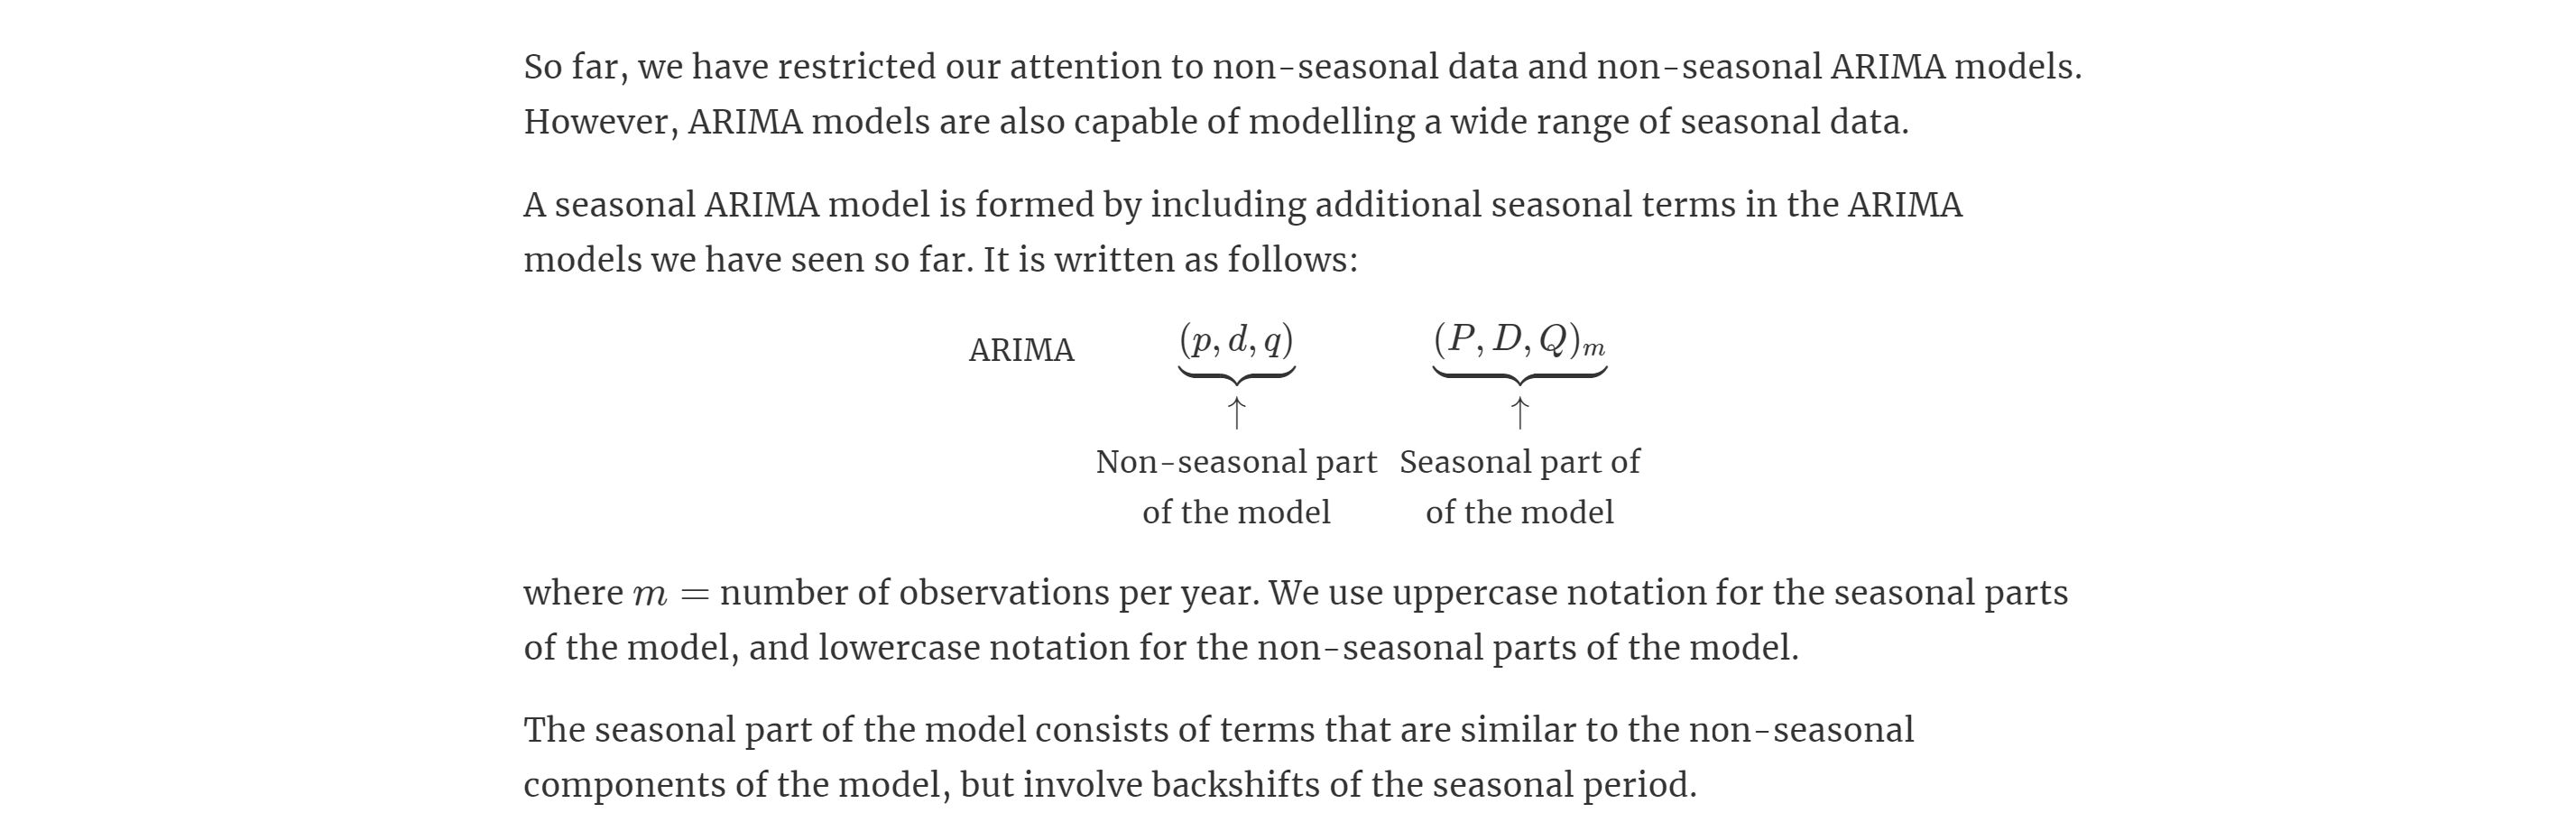

Using the ideas stated above, let us write consider $ARIMA(3,1,2)(0,1,1)_{12}$  model equation in the general form:


$$(1 - \phi_1 B - \phi_2 B^2 - \phi_3 B^3)(1 - B) (1-B^{12})y_t = (1+\theta_1 B + \theta_2 B^2)(1 + \Theta B^{12}) \epsilon_t$$


Let us open the brackets :

$$ (1 - B - B \phi_1 + B^2 \phi_1 - B^2 \phi_2 + B^3 \phi_2 - B^3 \phi_3 + B^4 \phi_3 - B^{12} + B^{13} + B^{13} \phi_1 - B^{14}\phi_1 + B^{14}\phi_2 - B^{15} \phi_2 + B^{15}\phi_3 - B^{16}\phi_3)y_t = (1 + B \theta_1 + B^2 \theta_2 + B^{12} \Theta + B^{13}\theta_1 \Theta + B^{14} \theta_2 \Theta) \epsilon_t$$

Note that $B$ is lag operator, hence $B^n y_t = y_{y-n}$. We use this idea when we expand the brackets:

$$ y_t - y_{t-1} -  \phi_1 y_{t-1} + \phi_1 y_{t-2} - \phi_2 y_{t-2} + \phi_2 y_{t - 3}- \phi_3 y_{t-3}+ \phi_3 y_{t-4} - y_{t-12} + y_{t-13} + \phi_1 y_{t-13} -\phi_1 y_{t-14}+ \phi_2 y_{t-14} - \phi_2 y_{t-15} + \phi_3 y_{t-15} - \phi_3 y_{t-16} = \epsilon_{t} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \Theta \epsilon_{t-12} + \theta_1 \Theta \epsilon_{t-13} + \theta_2 \Theta \epsilon_{t-14}$$

We have obtained the equation for $ARIMA(3,1,2)(0,1,1)_{12}$ in general form. Now, let us substitute the coefficients obtained by ```AutoARIMA```:  

$$ \Delta y_t   -  0.61 y_{t-1} + 0.61 y_{t-2} + 0.29 y_{t-2} -0.29 y_{t - 3} + 0.42 y_{t-3}-0.42 y_{t-4} - y_{t-12} + y_{t-13} + 0.61 y_{t-13} -0.61 y_{t-14}-0.29 y_{t-14} + 0.29 y_{t-15} - 0.42 y_{t-15} + 0.42 y_{t-16} = \epsilon_{t}  -0.32 \epsilon_{t-1} -0.58 \epsilon_{t-2} - 0.46 \epsilon_{t-12} + 0.14 \epsilon_{t-13} + 0.26 \epsilon_{t-14}$$

Check [this](https://stats.stackexchange.com/questions/69407/how-do-i-write-a-mathematical-equation-for-arima-2-1-0-x-0-2-2-period-12), [this](https://stats.stackexchange.com/questions/403363/arima-equation-formation) and [this](https://stats.stackexchange.com/questions/61510/how-do-i-write-a-mathematical-equation-for-arima-0-2-1-x-0-0-1-period-12) post on StackExchange. Writing the equation of the ARIMA model can be confusing sometimes, so you might consider these posts that explain it with other examples.

Sometimes, the orders of ARIMA can be defined using ACF and PCF plots.
“The ACF stands for Autocorrelation function and the PACF for Partial Autocorrelation function. Looking at these two plots together can help us form an idea of what models to fit.” However, today we focus mostly on sktime, so we do not use them in this tutorial.



## Splitting the Data, Fitting the Models and Getting Prediction <a name="spl"></a>

Let assume that we work for a medicine factory that tries predicting the demand for a10 products for the future to produce an optimal amount. We create a plan for each month, and the senior management should approve it. In this context, we have a train sample representing the target values that were observed before. As a test sample, we have new 24 months. It makes sense when we are not able to adjust the production during the test period, so we do not use a sliding window approach.

We are going to make prediction about value for the last 24 month of observations. Firstly, we will fit the simplest model without seasonality and then will check how seasonality improves the fit.

We will use ```ARIMA``` function from ```sktime.forecasting.arima``` module. Also, we show the prediction of NaiveForecaster and we will compare their performance using ```mean_absolute_percentage_error``` from sklearn.metrics. The explicit formula for MAPE is 
$$ \frac{1}{n}\sum_{i=1}^n \frac{ |y_i - \hat y_i|}{|y_i|} $$ 

Read [this](https://datascience.stackexchange.com/questions/77748/best-common-metric-for-comparing-classic-time-series-forecasting-methods-arima#:~:text=Prophet%20at%20least%20in%20the,so%20you%20should%20be%20fine.&text=MAPE%20and%20MASE%20are%20common,may%20not%20be%20familiar%20with.&text=You%20can%20consider%20also%20using,has%20a%20slightly%20different%20purpose.) to learn more about the metrics for time series.


We create train and test samples. Train represents the values that we observed; we will fit the model using these observations. Test sample represents the observation that our model has not seen yet and going to predict.

In [13]:
y_train, y_test = temporal_train_test_split(series, test_size=24)

An important step in predicting with sktime is the creation of ```ForecastingHorizon``` object based on ```y_test```.

In [14]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

Let us show our split on the plot. An exciting remark is that the data's greatest fluctuations are in the right part, i.e. in the test sample. It will be interesting to see how the models will cope with it.

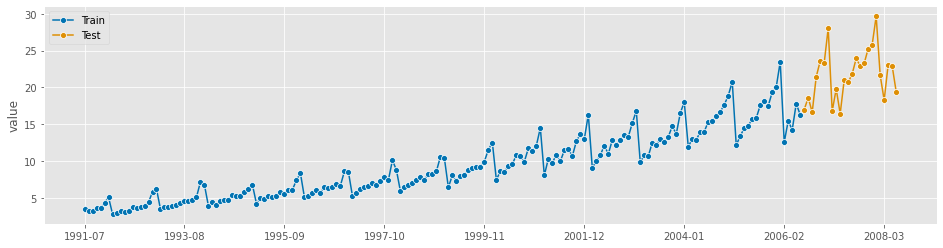

In [15]:
plot_series(y_train, y_test, labels=['Train', 'Test']);

#### NaiveForecaster

Now we are ready to fit the models and predict values for each one. The first model is [NaiveForecaster](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.naive.NaiveForecaster.html) with a seasonal periodicity equal to 12. We use ```last``` strategy because it is the default one. As an alternative, the user can use ```mean``` or ```drift```. For more information about strategies, check the [documentation](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.naive.NaiveForecaster.html).



```.fit()``` is used to train the model using observations from the train sample.

In [16]:
model = NaiveForecaster(strategy="last", sp=12).fit(y_train)

In order to get the forecast we use ```.predict()``` method. We put ForecastingHorizon ```fh```, as an argument.

In [17]:
y_pred = model.predict(fh)

The output is also a ```Series``` object.

In [18]:
print(type(y_pred))
print(y_pred)

<class 'pandas.core.series.Series'>
2006-07    15.829550
2006-08    17.554701
2006-09    18.100864
2006-10    17.496668
2006-11    19.347265
2006-12    20.031291
2007-01    23.486694
2007-02    12.536987
2007-03    15.467018
2007-04    14.233539
2007-05    17.783058
2007-06    16.291602
2007-07    15.829550
2007-08    17.554701
2007-09    18.100864
2007-10    17.496668
2007-11    19.347265
2007-12    20.031291
2008-01    23.486694
2008-02    12.536987
2008-03    15.467018
2008-04    14.233539
2008-05    17.783058
2008-06    16.291602
Freq: M, dtype: float64


We can visually see how well the model performed on this data. To do so, let us plot train, test and predicted data.

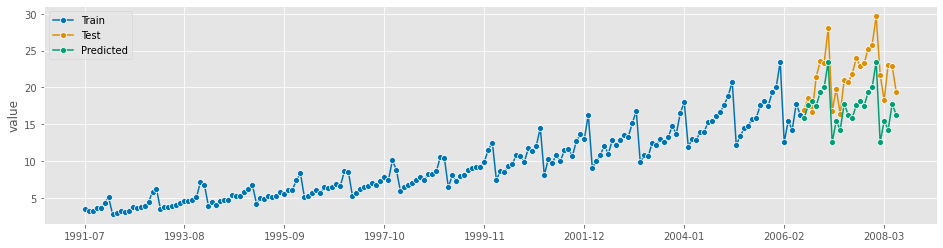

In [19]:
plot_series(y_train, y_test, y_pred, labels=['Train', 'Test', 'Predicted']);

We may just look only at the period when we needed to forecast.

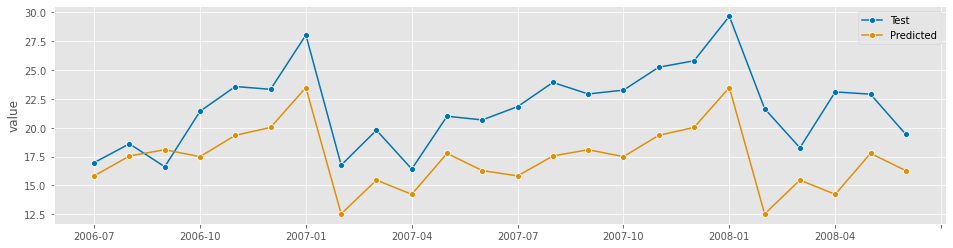

In [20]:
plot_series(y_test, y_pred, labels=['Test', 'Predicted']);

As the chart above illustrates, the Naïve Model with seasonality demonstrates a more-or-less good fit repeating some patterns from the initial data. However, the model underestimates the data at all the points.

We calculate MAE in order to compare the metrics later and say which model performed the best on the data.

In [21]:
mape_naive = mean_absolute_percentage_error(y_pred, y_test)
mape_naive

0.2685886622230329

The second and third models in out list ARIMA and ARIMA of the same order but with seasonality. 

### ARIMA Without Seasonality

 We use ```ARIMA``` function from ```sktime.forecasting.arima```. We specify the order of the model using tuple.   
 Recall, that for $ARIMA(p, d, q)$:
* $p$ represents auto regressive component
* $d$ represents the order of first-differencing
* $q$ represents moving average component


We again use ```.fit()``` method. For more details, consult the [documentation](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.arima.ARIMA.html).

In [22]:
model = ARIMA(order = (p, d, q)).fit(y_train)

sktime model has ```predict()``` method that allows to forecast values base on the forecasting horizon. ```ARIMA``` has an optional parameter ```return_pred_int``` that returns prediction interval.

In [23]:
y_pred, y_conf = model.predict(fh, return_pred_int=True)

As before, we can print the summary from model

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  180
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -329.126
Date:                Wed, 03 Mar 2021   AIC                            672.252
Time:                        17:42:07   BIC                            694.564
Sample:                             0   HQIC                           681.300
                                - 180                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1142      0.039      2.950      0.003       0.038       0.190
ar.L1         -0.6200      0.123     -5.055      0.000      -0.860      -0.380
ar.L2          0.2824      0.122      2.314      0.021       0.043       0.522
ar.L3         -0.0937      0.114     -0.818      0.413      -0.318       0.131
ma.L1          0.0276      0.069      0.400      0.689      -0.108       0.163
ma.L2         -0.9135      0.080    -11.485      0.000      -1.069      -0.758
sigma2         2.2775      0.239      9.540      0.000       1.810       2.745
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                64.10
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               6.55   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Visualization

It is always useful to analyses the performance of time series models using graphs. We have shown you how to plot series using ```plot_series```. Now, as promised, we will demonstrate how to do the same with ```matplotlib```. This method implies writing more code, however, you can configure it more flexibly.

Let us plot the initial data and predicted data together. The shaded are represents the confidence intervals.

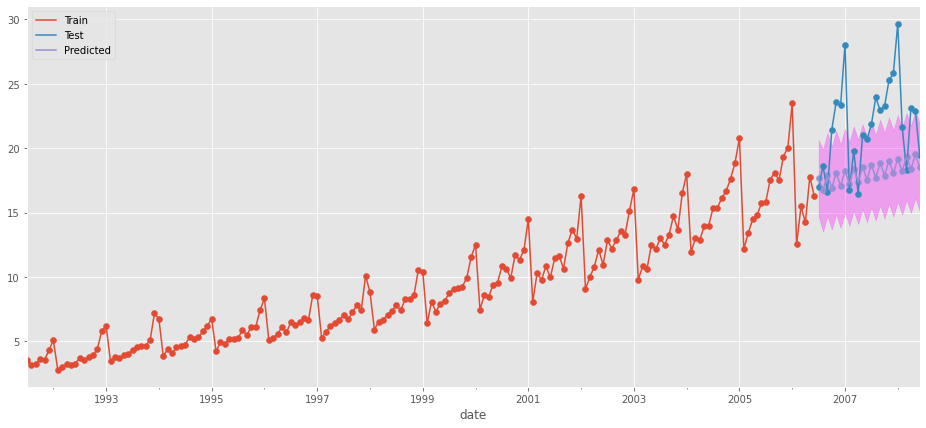

In [25]:
y_train.plot(label='Train')
y_test.plot(label='Test')
y_pred.plot(label='Predicted')

plt.fill_between(y_conf.index, y_conf.lower, y_conf.upper, color= 'magenta', alpha=.3)

plt.scatter(y_train.index, y_train)
plt.scatter(y_test.index, y_test)
plt.scatter(y_pred.index, y_pred)

plt.legend()
plt.show()

Take a closer look.

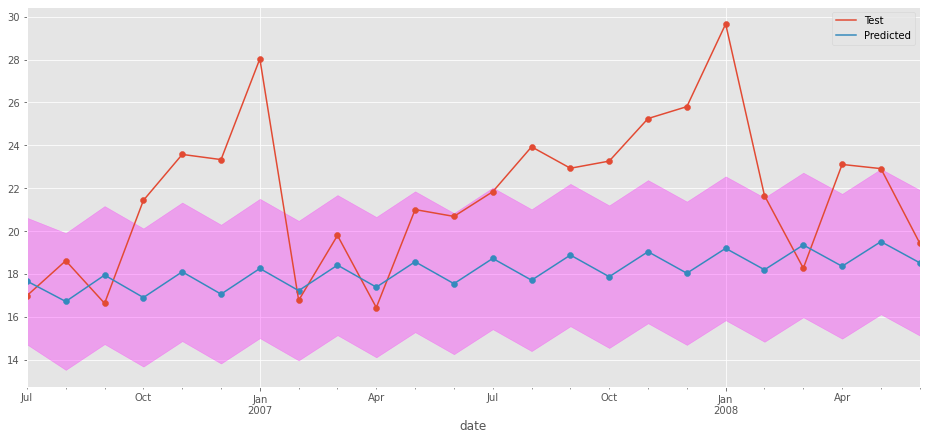

In [26]:
y_test.plot(label='Test')
y_pred.plot(label='Predicted')

plt.fill_between(y_conf.index, y_conf.lower, y_conf.upper, color= 'magenta', alpha= .3)

plt.scatter(y_test.index, y_test)
plt.scatter(y_pred.index, y_pred)

plt.legend()
plt.show()


As we can observe, ARIMA model without seasonality performed quite inferiorly. It seems to increase as the initial series, however, it replicates none of the fluctuations in the initial data.

Calculate MAE for future comparison.

In [27]:
mape_arima = mean_absolute_percentage_error(y_pred, y_test)
mape_arima

0.21820626616032612

### ARIMA With Seasonality

Finally, we reached the model that is expected to show the best performance on the data.
Note that even though the function ```ARIMA``` is the same as before, we specify the parameters ```seasonal_order``` to make it seasonal.


In [28]:
model = ARIMA(order = (p, d, q), seasonal_order = (P, D, Q, S)).fit(y_train)

Let us obtain predicted values and confidence interval putting ```fh``` as main argument to ```predict()``` method and setting  ```return_pred_int``` as ```True```.

In [29]:
y_pred, y_conf = model.predict(fh, return_pred_int=True)

In [30]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  180
Model:             SARIMAX(3, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -153.631
Date:                              Wed, 03 Mar 2021   AIC                            323.263
Time:                                      17:42:11   BIC                            348.207
Sample:                                           0   HQIC                           333.387
                                              - 180                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0073      0.003      2.614      0.009       0.002       0.013
ar.L1         -0.7702      0.378     -2.037      0.042      -1.511      -0.029
ar.L2          0.3533      0.094      3.758      0.000       0.169       0.538
ar.L3          0.3158      0.118      2.675      0.007       0.084       0.547
ma.L1         -0.2012      0.403     -0.499      0.618      -0.992       0.589
ma.L2         -0.7826      0.386     -2.026      0.043      -1.539      -0.026
ma.S.L12      -0.2316      0.071     -3.268      0.001      -0.370      -0.093
sigma2         0.3590      0.038      9.354      0.000       0.284       0.434
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 2.62
Prob(Q):                              0.67   Prob(JB):                         0.27
Heteroskedasticity (H):               4.60   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

It is always useful to analyse the performance of time series models using graphs. We have shown you how to plot series using ```plot_series```. Now, as promised, we will demonstrate how to do the same with ```matplotlib```.

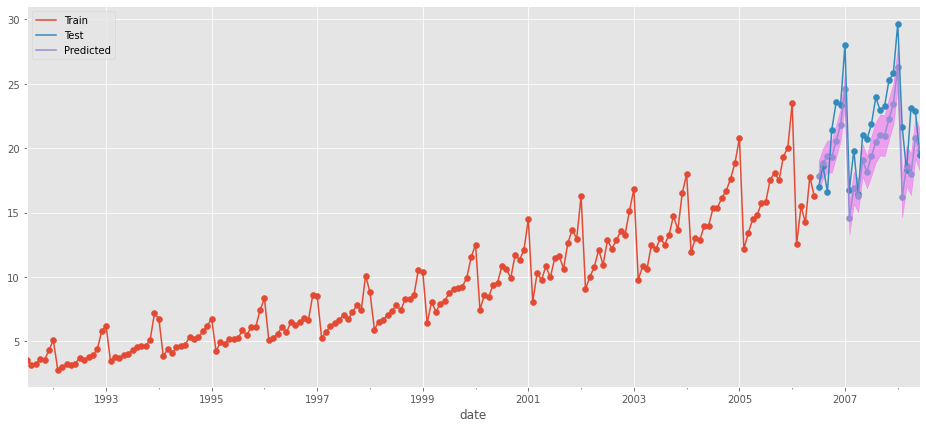

In [31]:
y_train.plot(label='Train')
y_test.plot(label='Test')
y_pred.plot(label='Predicted')

plt.fill_between(y_conf.index, y_conf.lower, y_conf.upper, color= 'magenta', alpha=.3)

plt.scatter(y_train.index, y_train)
plt.scatter(y_test.index, y_test)
plt.scatter(y_pred.index, y_pred)

plt.legend()
plt.show()

At first glance, this model performed magnificently. Let us take a closer look. 

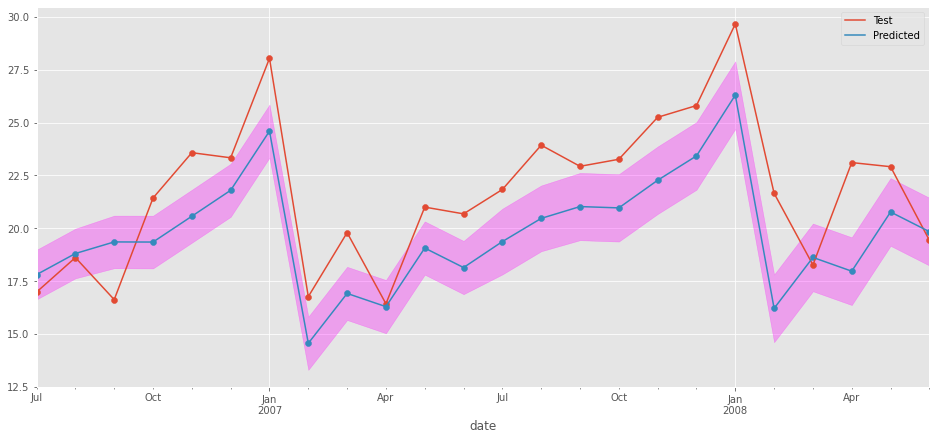

In [32]:
y_test.plot(label='Test')
y_pred.plot(label='Predicted')

plt.fill_between(y_conf.index, y_conf.lower, y_conf.upper, color= 'magenta', alpha= .3)

plt.scatter(y_test.index, y_test)
plt.scatter(y_pred.index, y_pred)

plt.legend()
plt.show()


Indeed, taking into account seasonality improves the model prediction significantly. Apart from replicating the main trends and fluctuations of the initial data, this model predicts the peak point rather accurately.

In [33]:
mape_arima_seas = mean_absolute_percentage_error(y_pred, y_test)
mape_arima_seas

0.11912080890960701

## Comparison <a name="comp"></a>

Let us compare the metrics for all these three models and say which is the best. Expectedly, the last model did the best, and its MAE is the lowest. However, it was anticipated that Arima without seasonality showed a better score than NaiveForecaster. Visually the latter showed a better fit.

In [34]:
print("Naive Model \t \t", mape_naive)
print("Arima no Seas.\t \t", mape_arima)
print("Arima with Seas.\t", mape_arima_seas)

Naive Model 	 	 0.2685886622230329
Arima no Seas.	 	 0.21820626616032612
Arima with Seas.	 0.11912080890960701


As we can see, both from the plot and the metric, the Arima model with seasonality demonstrated the best fit. It is important to note that the Naïve forecaster model with seasonality was slightly worse than the Arima model with seasonality visibly. 

Remark. We could notice that the amplitude increases each year. One interesting approach would be the logarithm transformation to the initial series. In this way, the data will still increase, however, the amplitude of fluctuations won’t. 

In [35]:
series_log = series.apply(np.log)

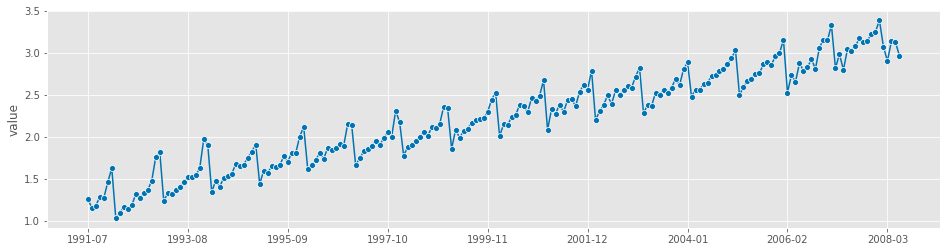

In [36]:
plot_series(series_log);

## Sliding Window <a name="sld"></a>

Now let us assume that we can change the production plan of A10 medicine each month based on sales during the previous n month.
We will perform a prediction using the [sliding window approach](https://machinelearningmastery.com/time-series-forecasting-supervised-learning/).

For example, train sample on each iteration looks likes this:



<img src="https://miro.medium.com/max/1912/1*HN084lMD15SWjH6epVeSAg.gif" width="450" align="center">



"Sliding window is the way to restructure a time series dataset as a supervised learning problem. Multivariate and multi-step forecasting time series can also be framed as supervised learning using the sliding window method."

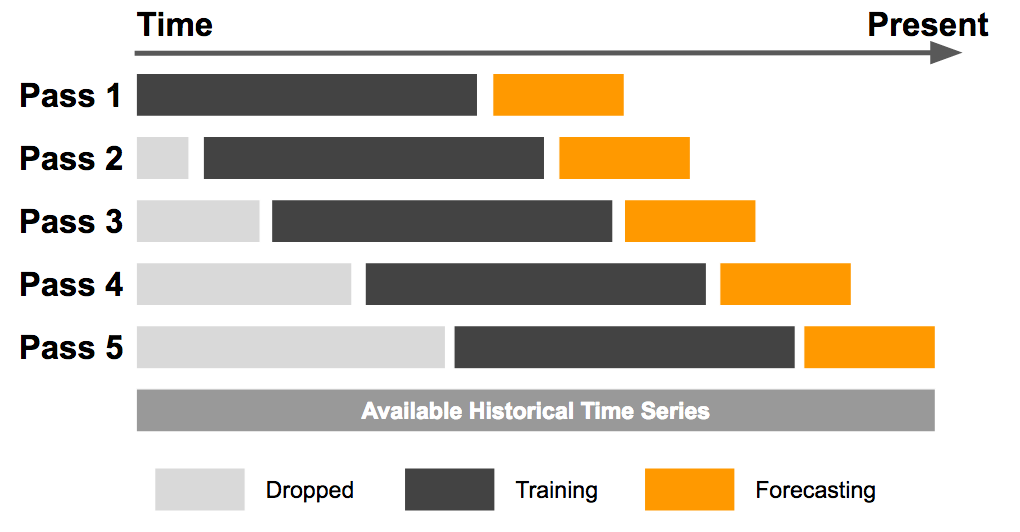

Let us implement it in python. We use [SlidingWindowSplitter](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.model_selection.SlidingWindowSplitter.html) from sktime.

We will start with forecasting with ARIMA model without seasonality. For easier usage of the above mentioned SlidingWindowSplitter, we will be using ForecastingGridSearchCV:

In [37]:
fh = ForecastingHorizon(series[-24:].index, is_relative=False)

y_predA, y_confA = ForecastingGridSearchCV(ARIMA(), SlidingWindowSplitter(window_length=48, start_with_window=True, initial_window=48),
                              {'order': [(p, d, q)]}, n_jobs=-1).fit(series).predict(fh, return_pred_int=True)

Now, let us do the same, but with seasonality introduced in our model:

In [ ]:
y_predAS, y_confAS = ForecastingGridSearchCV(ARIMA(), SlidingWindowSplitter(window_length=48, start_with_window=True, initial_window=48),
                              {'order': [(p, d, q)], 'seasonal_order': [(P, D, Q, S)]}, n_jobs=-1).fit(series).predict(fh, return_pred_int=True)

And for the naive forcaster for good measure:

In [ ]:
y_predN = ForecastingGridSearchCV(NaiveForecaster(), SlidingWindowSplitter(window_length=48, start_with_window=True, initial_window=48),
                              {'strategy': ["last"], 'sp': [12]}, n_jobs=-1).fit(series).predict(fh)

We can now look at the generated errors. As you can see, the model with seasonality has given us the best performance, while the naive approach, quite predictibly, gave us the worst result.

In [ ]:
errors_arima = (mean_absolute_percentage_error(series[-24:], y_predA))
errors_arima_seas = (mean_absolute_percentage_error(series[-24:], y_predAS))
errors_naive = (mean_absolute_percentage_error(series[-24:], y_predN))

In [ ]:
print("Naive Model \t \t", np.mean(errors_naive))
print("Arima no Seas.\t \t", np.mean(errors_arima))
print("Arima with Seas.\t", np.mean(errors_arima_seas))

Naive Model 	 	 0.1459047111772603
Arima no Seas.	 	 0.1273784113895762
Arima with Seas.	 0.07357140381399513


We may see that the prediction with sliding window expectedly showed a better fit than prediction using only one train and one test samples. However, as before, let us the model performance on the graphs.

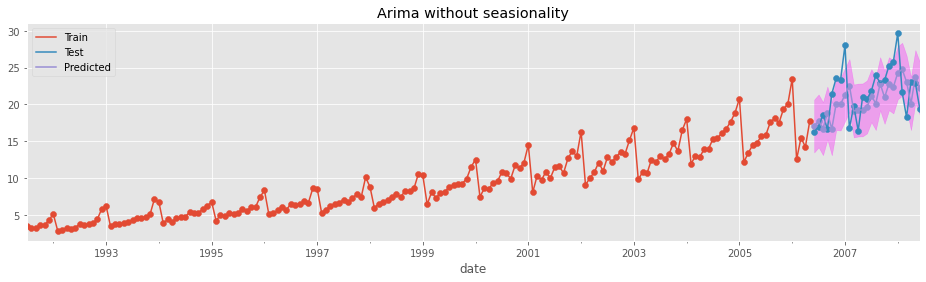

------------------------------------------------------------------------------------------------------------------------------------------------------


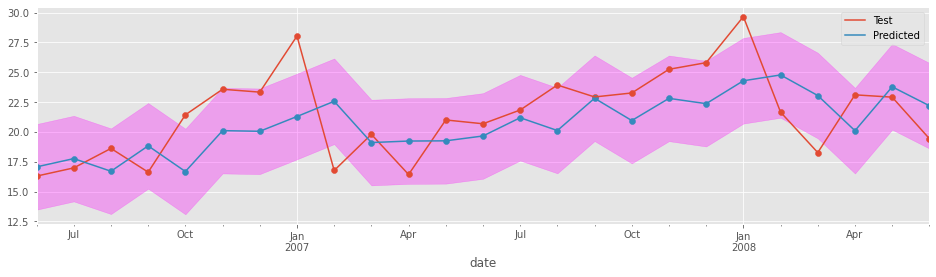

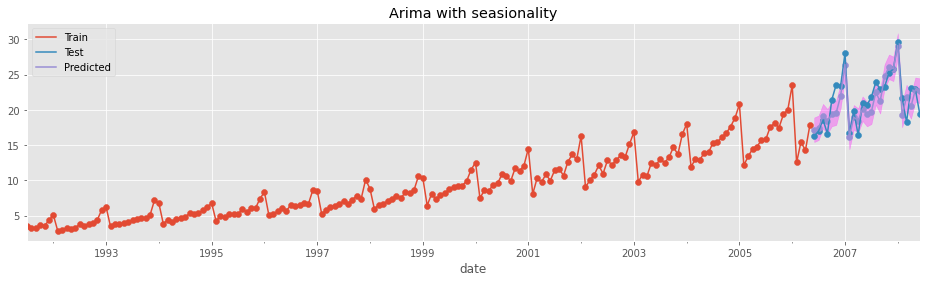

------------------------------------------------------------------------------------------------------------------------------------------------------


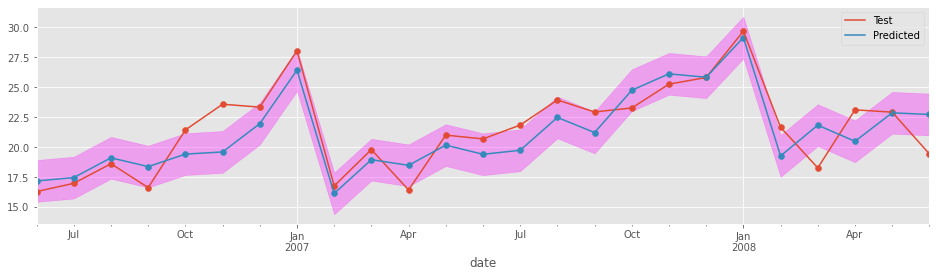

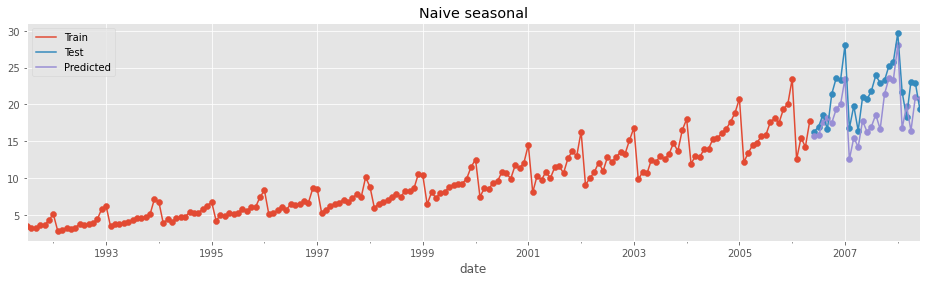

------------------------------------------------------------------------------------------------------------------------------------------------------


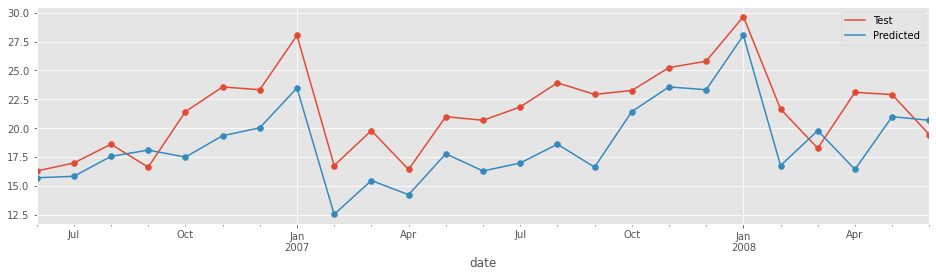

In [ ]:
for y_pred, y_conf, title in [(y_predA, y_confA, 'Arima without seasionality'),
                       (y_predAS, y_confAS, 'Arima with seasionality'), (y_predN, False, 'Naive seasonal')]:
    plt.figure(figsize=(16,4))
    plt.title(title)
    series[:-24].plot(label='Train')
    series[-24:].plot(label='Test')
    y_pred.plot(label='Predicted')

    if type(y_conf) != bool:
      plt.fill_between(y_conf.index, y_conf.lower, y_conf.upper, color= 'magenta', alpha=.3)

    plt.scatter(series[:-24].index, series[:-24])
    plt.scatter(series[-24:].index, series[-24:])
    plt.scatter(y_pred.index, y_pred)

    plt.legend()
    plt.show()
    print("-"*150)
    plt.figure(figsize=(16,4))
    series[-24:].plot(label='Test')
    y_pred.plot(label='Predicted')

    if type(y_conf) != bool:
      plt.fill_between(y_conf.index, y_conf.lower, y_conf.upper, color= 'magenta', alpha=.3)

    plt.scatter(series[-24:].index, series[-24:])
    plt.scatter(y_pred.index, y_pred)
   
    plt.legend()
    plt.show()

As the plots above show, all of the models performed quite decently.

## Conclusion <a name="end"></a>

So, as a result of our work, we have looked at various methods of forecasting data, which has seasonality in place. We have skimmed through ARIMA models with seasonality and without one. The conclusion is evident: The model, which had the seasonality set correctly, has given us the supreme performance in comparison with the more trivial ones, further proving the point that it is extremely important to overview the data before the analysis.
P.S. It was really exciting and inspiring to work on this tutorial. We’ve learned a lot and are looking forward to continue working on such tasks. 


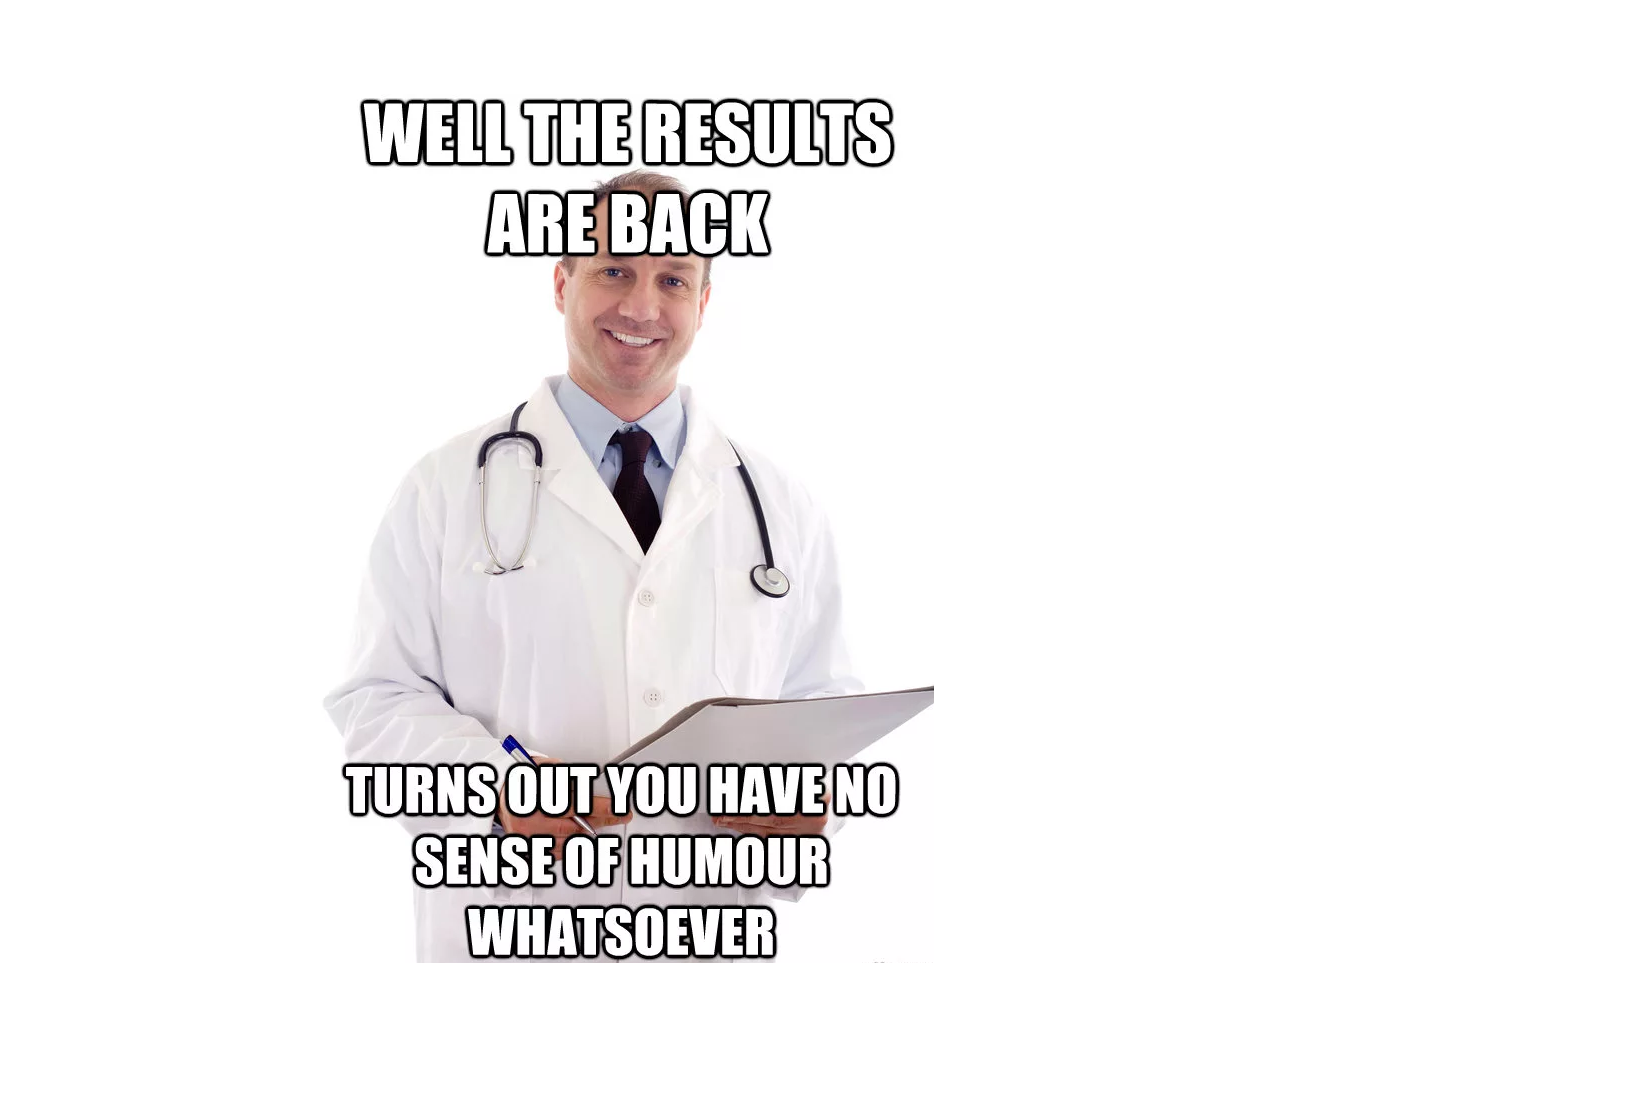